# Behaviorial Cloning Project

Overview
---
This repository contains starting files for the Behavioral Cloning Project.

In this project, you will use what you've learned about deep neural networks and convolutional neural networks to clone driving behavior. You will train, validate and test a model using Keras. The model will output a steering angle to an autonomous vehicle.

We have provided a simulator where you can steer a car around a track for data collection. You'll use image data and steering angles to train a neural network and then use this model to drive the car autonomously around the track.

To meet specifications, the project will require submitting five files: 
* model.py (script used to create and train the model)
* drive.py (script to drive the car - feel free to modify this file)
* model.h5 (a trained Keras model)
* a report writeup file (either markdown or pdf)
* video.mp4 (a video recording of your vehicle driving autonomously around the track for at least one full lap)

Simulator shown as following:

![](resources/lake.jpg)
![](resources/jungle.jpg)
<center>Figure 1.Simulation</center>


---
## Step 0: Read Config Data from .csv file

In [1]:
import csv
import cv2
import numpy as np
from itertools import islice 
import matplotlib.image as mpimg
from matplotlib import pyplot as plt 

def readindexfromconfig(path):
    """"
    read index from config file
    
    Arguments:
        path: source csv file
    """
    temp_lines = []
    with open(path) as csvfile:
        reader = csv.reader(csvfile)
        for line in islice(reader, 1, None):
            temp_lines.append(line)
    return temp_lines

In [2]:
lines = readindexfromconfig('./data/driving_log.csv')
# lines = readindexfromconfig('./windows_sim/data/driving_log.csv')

print("Total record length: {}".format(len(lines)))

Total record length: 8036


### Random show images from left,center,right viewpoint

In [3]:
def readfromfile(line,sourcepathindex='./data/IMG/',correction = 0.25):
    img_center_path = sourcepathindex + line[0].split('/')[-1]
    img_left_path = sourcepathindex + line[1].split('/')[-1]
    img_right_path = sourcepathindex+ line[2].split('/')[-1]

    img_center = mpimg.imread(img_center_path)
    img_left = mpimg.imread(img_left_path)
    img_right = mpimg.imread(img_right_path)

    steering_center = float(line[3])
    steering_left = steering_center + correction
    steering_right = steering_center - correction
    
    return img_left,img_center,img_right,steering_left,steering_center,steering_right
    
def randomshowviewpoint(lines,sourcepathindex='./data/IMG/'):
    line = lines[np.random.randint(len(lines))]
    
    img_left,img_center,img_right,steering_left,steering_center,steering_right = readfromfile(line,sourcepathindex)
    
    plt.figure(figsize=(16, 16))
    plt.subplot(1,3,1)
    plt.imshow(img_left)
    plt.title('Left Image,steering angle.{:.3f}'.format(steering_left))
    plt.yticks([])
    plt.xticks([])
    
    plt.subplot(1,3,2)
    plt.imshow(img_center)
    plt.title('Center Image,steering angle.{:.3f}'.format(steering_center))
    plt.yticks([])
    plt.xticks([])
    
    plt.subplot(1,3,3)
    plt.imshow(img_right)
    plt.title('Right Image ,steering angle.{:.3f}'.format(steering_right))
    plt.yticks([])
    plt.xticks([])

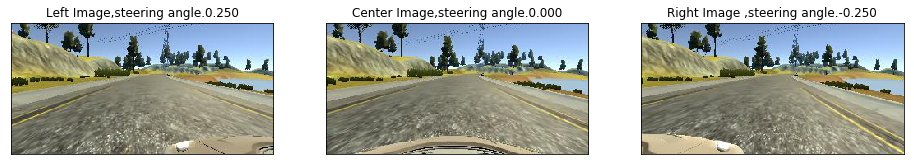

In [4]:
randomshowviewpoint(lines)

### Generate images and steering angles dataset

In [5]:
def generatedataset(lines,sourcepathindex='./data/IMG/'):
    car_images =[]
    steering_angles =[]
    
    for line in lines:
        img_left,img_center,img_right,steering_left,steering_center,steering_right = readfromfile(line,sourcepathindex)
    
        car_images.append(img_center)
        car_images.append(img_left)
        car_images.append(img_right)
    
        steering_angles.append(steering_center)
        steering_angles.append(steering_left)
        steering_angles.append(steering_right)
    
    X_image = np.array(car_images)
    y_label = np.array(steering_angles)
    return X_image,y_label

In [6]:
# X_train,y_train = generatedataset(lines)

# print(X_train.shape)
# print(y_train.shape)

## Step 1:Data Augument Data Set function

In [7]:
import cv2
from skimage import io, color, exposure, transform
from skimage.util import random_noise


def gamma_correction(img, correction):
    """"
    Gamma correction function
    
    """
    img = img/255.0
    img = cv2.pow(img, correction)
    return np.uint8(img*255)

def gammaImage(img,steering,gammarate= 0.8):
    """"
    Gamma correction function as expection of brightness lighting conditions
    
    """
    HSV = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)   
#     HSV[:,:,2] = gamma_correction((HSV[:,:,2]),2)
    HSV[:,:,2] = gamma_correction((HSV[:,:,2]),(2*gammarate * np.random.random_sample(1) + 1-gammarate))
    img = cv2.cvtColor(HSV, cv2.COLOR_HSV2RGB )
    return img,steering

def gaussian_blur(img,steering,kernel_size=3):
    """"
    Gaussian blur function as expection of motion-blur
    
    """
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0),steering

def gaussian_noise(img,steering):
    """"
    Gaussian noise function as expection of noise
    
    """
    var = 0.01*np.random.random_sample(1)
    return np.uint8(255*random_noise(img/255, mode="gaussian",var=var)),steering

def random_erase(img,steering, hlimt=90,wlimit=90):
    """"
    Gaussian erase function as expection of occlusions or physical damage
    
    """
    imgshape = img.shape
    h = np.random.randint(0, hlimt)
    w = np.random.randint(0, wlimit)
    x1 = np.random.randint(0, imgshape[0] - h)
    y1 = np.random.randint(0, imgshape[1] - w)
    cropimg =np.copy(img)
    cropimg[x1:x1+h, y1:y1+w,0] = 127
    cropimg[x1:x1+h, y1:y1+w,1] = 127
    cropimg[x1:x1+h, y1:y1+w,2] = 127
    return cropimg,steering

def image_flip(image,steering):
    image,steering=cv2.flip(image,1),steering*-1.0
    return image,steering

def image_trans(image, steering,trans_range = 100):
    """ Returns translated image and 
    corrsponding steering angle.
    """
    w = image.shape[0]
    h = image.shape[1]
    tr_x = trans_range * (np.random.uniform() - 1.0/ 2)
    steering = steering + tr_x / trans_range  * (trans_range/w)
    tr_y = 0
    M = np.float32([[1, 0, tr_x], [0, 1, tr_y]])
    image = cv2.warpAffine(image, M, (h,w))
    return image, steering

In [8]:
def showimagelabel(image,label):
    plt.imshow(image)
    plt.title('Image,steering angle.{:.3f}'.format(label))
    plt.yticks([])
    plt.xticks([])

### Original image taken from dataset

(3, 160, 320, 3)
(3,)


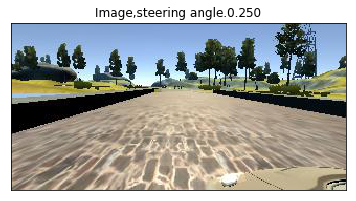

In [9]:
image,label = generatedataset(lines[0:1])

print(image.shape)
print(label.shape)

testimage = image[1]
testlabel = label[1]

showimagelabel(testimage,testlabel)

### flip function test

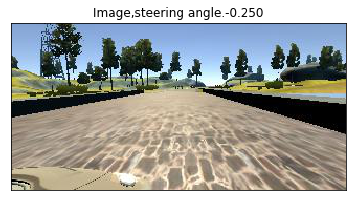

In [10]:
imageflip,labelflip = image_flip(testimage,testlabel)
showimagelabel(imageflip,labelflip)

### gammaImage function test 

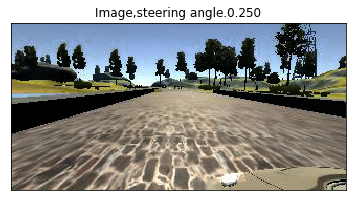

In [11]:
imagegramma,labelgramma = gammaImage(testimage,testlabel)
showimagelabel(imagegramma,labelgramma)

###  gaussian_blur

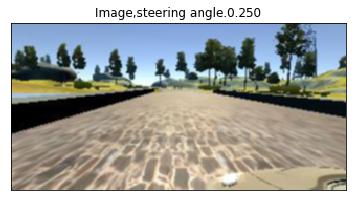

In [12]:
imageblur,labelblur = gaussian_blur(testimage,testlabel)
showimagelabel(imageblur,labelblur)

### gaussian_noise

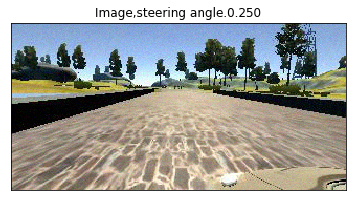

In [13]:
imagenoise,labelnoise = gaussian_noise(testimage,testlabel)
showimagelabel(imagenoise,labelnoise)

### random_erase

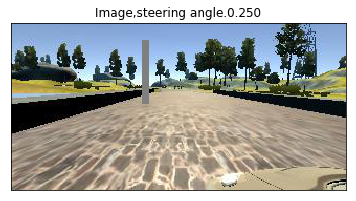

In [14]:
imageearse,labelearse = random_erase(testimage,testlabel)
showimagelabel(imageearse,labelearse)

### image_trans

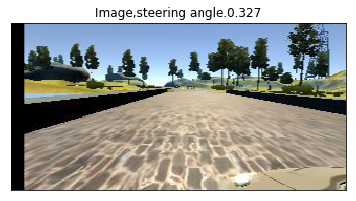

In [15]:
imagetrans,labeletrans = image_trans(testimage,testlabel)
showimagelabel(imagetrans,labeletrans)

### Augument dataset combination

In [16]:
def DataAugumentProcess(imgbatch,labelbatch,gammarate = 0.5,blurrate = 0.5,randomeraserte=0.5,randomtrans=0.4):
    """"
    Data Augumention Process function
    
    """
    car_images = []
    steering_angles = []
            
    for batch_image,batch_label in zip(imgbatch,labelbatch):
        img = batch_image
        label = batch_label
        if(np.random.random_sample(1) < gammarate):
            img,label = gammaImage(img,label)
        
        if(np.random.random_sample(1) < blurrate):
            img,label = gaussian_blur(img,label)
        
        if(np.random.random_sample(1) < randomeraserte):
            img,label = random_erase(img,label)
        
        if(np.random.random_sample(1) < randomtrans):
            img,label = image_trans(img,label)
            
        img,label = gaussian_noise(img,label)
        
        car_images.append(img)
        steering_angles.append(label)
        
        imageflip,labelflip = image_flip(batch_image,batch_label)
        img = imageflip
        label = labelflip
        
        if(np.random.random_sample(1) < gammarate):
            img,label = gammaImage(img,label)
        
        if(np.random.random_sample(1) < blurrate):
            img,label = gaussian_blur(img,label)
        
        if(np.random.random_sample(1) < randomeraserte):
            img,label = random_erase(img,label)
        
        if(np.random.random_sample(1) < randomtrans):
            img,label = image_trans(img,label)
        
        car_images.append(img)
        steering_angles.append(label)
    
    X_image = np.array(car_images)
    y_label = np.array(steering_angles)
    
    return X_image,y_label

### Augument dataset combination test

(6, 160, 320, 3)
(6,)


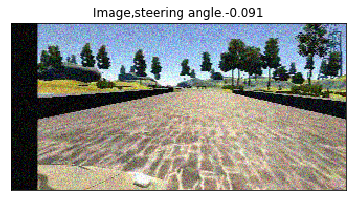

In [17]:
X_train_test,y_train_test = DataAugumentProcess(image,label)

print(X_train_test.shape)
print(y_train_test.shape)

showimagelabel(X_train_test[4],y_train_test[4])

### Cropping function

In [24]:
def croppingfunction(img,top_crop=70, bottom_crop=25,left_crop=0, right_crop=0):
    w = img.shape[0]
    h = img.shape[1]

    print(img.shape)
    plt.figure(figsize=(16, 16))
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.title('Augument Original Image')
#     plt.yticks([])
#     plt.xticks([])

    plt.subplot(1,2,2)
    plt.imshow(img[w-top_crop:w-bottom_crop, left_crop:h-right_crop])
    plt.title('Cropped Image')
#     plt.yticks([])
#     plt.xticks([])

(160, 320, 3)


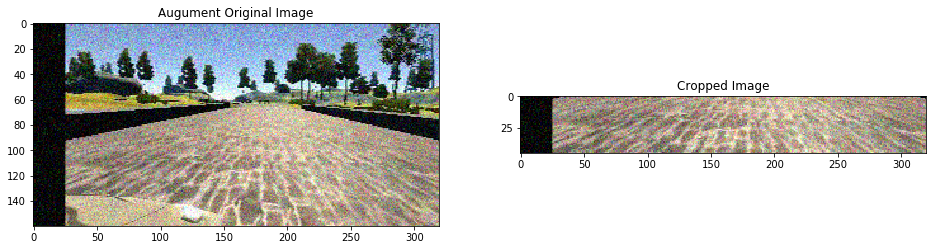

In [25]:
croppingfunction(X_train_test[4])

## Step 2: Generator of images and steering angles definition

In [20]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split


samples = lines

train_samples, validation_samples = train_test_split(samples, test_size=0.2)

BATCH_SIZE = 64

def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

#             for batch_sample in batch_samples:
                
            image,label = generatedataset(batch_samples)
                
            X_train,y_train = DataAugumentProcess(image,label)
            
            yield shuffle(X_train, y_train)

# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=BATCH_SIZE)
validation_generator = generator(validation_samples, batch_size=BATCH_SIZE)

## Step 3: Generate ages and steering angles diretly

In [21]:
lines = readindexfromconfig('./data/driving_log.csv')
X_train_base,y_train_base = generatedataset(lines)

print(X_train_base.shape)
print(y_train_base.shape)

(24108, 160, 320, 3)
(24108,)


In [ ]:
X_train,y_train = DataAugumentProcess(X_train_base,y_train_base)

print(X_train.shape)
print(y_train.shape)

In [ ]:
import pickle

train_dataset_file = "gen_train.p"

print("Number of training examples after augmenting and balancing training data =", X_train.shape[0])
pickle.dump({
        "features" : X_train,
        "labels" : y_train
    }, open(train_dataset_file, "wb" ),protocol=4)
print("Generated balanced dataset saved in", train_dataset_file)

In [22]:
import pickle

train_dataset_file = "gen_train.p"

with open(train_dataset_file, mode='rb') as f:
    gen_train = pickle.load(f)
    
X_train, y_train = gen_train['features'], gen_train['labels']
print("Number of training examples after augmenting and balancing training data =", X_train.shape[0])

Number of training examples after augmenting and balancing training data = 48216


## Step 4: Model Archieture

In [21]:
import keras

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Convolution2D, Dropout,Lambda,MaxPooling2D, Cropping2D
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model
import matplotlib.pyplot as plt
from keras import regularizers

input_shape=(160,320,3)

model = Sequential()

model.add(Lambda(lambda x:((x /255.0)-0.5),input_shape=input_shape))
model.add(Cropping2D(cropping=((70,25), (0,0))))

# model.add(Conv2D(6, kernel_size=(5, 5),activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Conv2D(16, (5, 5), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))
# model.add(Flatten())
# model.add(Dense(120, activation='relu'))  
# model.add(Dropout(0.15))
# model.add(Dense(84, activation='relu'))  
# model.add(Dropout(0.05))
# model.add(Dense(1)) 

regr = 0.0005
model.add(Convolution2D(24,(5,5), strides=(2,2), activation='relu',kernel_regularizer=regularizers.l2(regr)))
model.add(Convolution2D(36,(5,5), strides=(2,2), activation='relu',kernel_regularizer=regularizers.l2(regr)))
model.add(Convolution2D(48,(5,5), strides=(2,2), activation='relu',kernel_regularizer=regularizers.l2(regr)))
model.add(Convolution2D(64,(3,3), activation='relu',kernel_regularizer=regularizers.l2(regr)))
model.add(Convolution2D(64,(3,3), activation='relu',kernel_regularizer=regularizers.l2(regr)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(100,kernel_regularizer=regularizers.l2(regr)))
model.add(Dropout(0.25))
model.add(Dense(50,kernel_regularizer=regularizers.l2(regr)))
model.add(Dropout(0.25))
model.add(Dense(10,kernel_regularizer=regularizers.l2(regr)))
model.add(Dropout(0.1))
model.add(Dense(1))

model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 160, 320, 3)       0         
_________________________________________________________________
cropping2d_1 (Cropping2D)    (None, 65, 320, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 31, 158, 24)       1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 77, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 37, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 35, 64)         27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 33, 64)         36928     
__________

## Step 5: Train Model

In [23]:
def trainmodel(models,X_train_data,y_train_data,lr=0.0005,batch_size=128,epochs=50,patience=10,savefile='model.h5'):
    adam = keras.optimizers.Adam(lr=lr)
    models.compile(loss='mse',optimizer=adam)

    rarlystop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=patience, verbose=0, mode='auto')

# history_object = model.fit_generator(train_generator, steps_per_epoch=len(train_samples)/BATCH_SIZE, \
#                                      validation_data=validation_generator,validation_steps=len(validation_samples)/BATCH_SIZE, \
#                                      callbacks = [rarlystop],\
#                                      epochs=30)

# history_object = model.fit_generator(train_generator, steps_per_epoch=20, \
#                                      validation_data=validation_generator,validation_steps=10, \
#                                      callbacks = [rarlystop],\
#                                      epochs=30)

    history_object = models.fit(X_train_data, y_train_data, batch_size=128,epochs=epochs,shuffle=True,verbose=1,\
                           validation_split=0.1,callbacks=[rarlystop])  

    models.save(savefile)

    ### print the keys contained in the history object
    print(history_object.history.keys())

    ### plot the training and validation loss for each epoch
    plt.plot(history_object.history['loss'])
    plt.plot(history_object.history['val_loss'])
    plt.title('model mean squared error loss')
    plt.ylabel('mean squared error loss')
    plt.xlabel('epoch')
    plt.legend(['training set', 'validation set'], loc='upper right')
    plt.show()

Train on 43394 samples, validate on 4822 samples
Epoch 1/50
43394/43394 [==============================] - 34s 794us/step - loss: 0.1251 - val_loss: 0.0643
Epoch 2/50
43394/43394 [==============================] - 33s 759us/step - loss: 0.0499 - val_loss: 0.0408
Epoch 3/50
43394/43394 [==============================] - 34s 773us/step - loss: 0.0367 - val_loss: 0.0336
Epoch 4/50
43394/43394 [==============================] - 33s 771us/step - loss: 0.0322 - val_loss: 0.0318
Epoch 5/50
43394/43394 [==============================] - 33s 772us/step - loss: 0.0304 - val_loss: 0.0302
Epoch 6/50
43394/43394 [==============================] - 33s 770us/step - loss: 0.0291 - val_loss: 0.0312
Epoch 7/50
43394/43394 [==============================] - 34s 774us/step - loss: 0.0285 - val_loss: 0.0288
Epoch 8/50
43394/43394 [==============================] - 34s 788us/step - loss: 0.0282 - val_loss: 0.0295
Epoch 9/50
43394/43394 [==============================] - 34s 777us/step - loss: 0.0283 - val_l

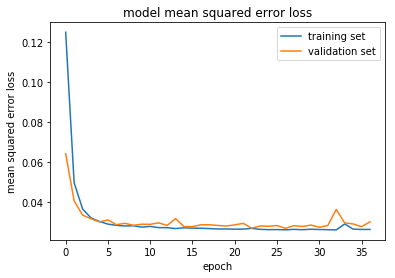

In [50]:
trainmodel(model,X_train,y_train)

## Step 6: Model Fine tune

In [24]:
import keras
from keras.models import load_model

def finetunemodel(X_train_data,y_train_data,lr=0.0001,loadfile='model.h5'):
    models = load_model(loadfile)
    trainmodel(models,X_train_data,y_train_data,lr=lr,savefile=loadfile)

Train on 43394 samples, validate on 4822 samples
Epoch 1/50
43394/43394 [==============================] - 33s 766us/step - loss: 0.0251 - val_loss: 0.0268
Epoch 2/50
43394/43394 [==============================] - 31s 725us/step - loss: 0.0249 - val_loss: 0.0266
Epoch 3/50
43394/43394 [==============================] - 31s 722us/step - loss: 0.0249 - val_loss: 0.0269
Epoch 4/50
43394/43394 [==============================] - 32s 727us/step - loss: 0.0247 - val_loss: 0.0267
Epoch 5/50
43394/43394 [==============================] - 31s 725us/step - loss: 0.0247 - val_loss: 0.0268
Epoch 6/50
43394/43394 [==============================] - 31s 723us/step - loss: 0.0248 - val_loss: 0.0273
Epoch 7/50
43394/43394 [==============================] - 31s 724us/step - loss: 0.0247 - val_loss: 0.0264
Epoch 8/50
43394/43394 [==============================] - 32s 726us/step - loss: 0.0246 - val_loss: 0.0265
Epoch 9/50
43394/43394 [==============================] - 31s 723us/step - loss: 0.0246 - val_l

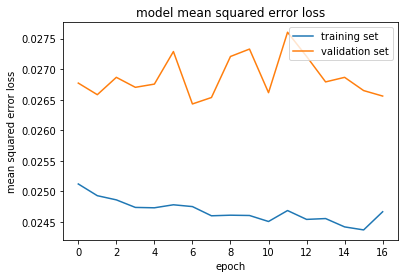

In [52]:
finetunemodel(X_train,y_train,lr=0.0001)

## Step 7: Simulator test

#### Saving a video of the autonomous agent

Creates a video based on images found in the `run1` directory. The name of the video will be the name of the directory followed by `'.mp4'`, so, in this case the video will be `run1.mp4`.

```
python drive.py model.h5 run1

python video.py run1
```

In [22]:
from IPython.display import HTML

video_output = 'run1.mp4'

HTML("""
<video width="320" height="160" controls>
  <source src="{0}">
</video>
""".format(video_output))

## Step 7: Model Fine tuned to another jungle dataset

In [25]:
lines = readindexfromconfig('./windows_sim/data/driving_log.csv')
X_train_base,y_train_base = generatedataset(lines,'')

print(X_train_base.shape)
print(y_train_base.shape)

(37182, 160, 320, 3)
(37182,)


In [26]:
X_train,y_train = DataAugumentProcess(X_train_base,y_train_base)

print(X_train.shape)
print(y_train.shape)

(74364, 160, 320, 3)
(74364,)


Train on 66927 samples, validate on 7437 samples
Epoch 1/50
66927/66927 [==============================] - 71s 1ms/step - loss: 0.1138 - val_loss: 0.1326
Epoch 2/50
66927/66927 [==============================] - 48s 710us/step - loss: 0.1130 - val_loss: 0.1315
Epoch 3/50
66927/66927 [==============================] - 48s 711us/step - loss: 0.1133 - val_loss: 0.1315
Epoch 4/50
66927/66927 [==============================] - 48s 712us/step - loss: 0.1124 - val_loss: 0.1289
Epoch 5/50
66927/66927 [==============================] - 47s 708us/step - loss: 0.1126 - val_loss: 0.1293
Epoch 6/50
66927/66927 [==============================] - 47s 706us/step - loss: 0.1125 - val_loss: 0.1303
Epoch 7/50
66927/66927 [==============================] - 47s 700us/step - loss: 0.1118 - val_loss: 0.1324
Epoch 8/50
66927/66927 [==============================] - 47s 704us/step - loss: 0.1120 - val_loss: 0.1287
Epoch 9/50
66927/66927 [==============================] - 47s 700us/step - loss: 0.1118 - val_los

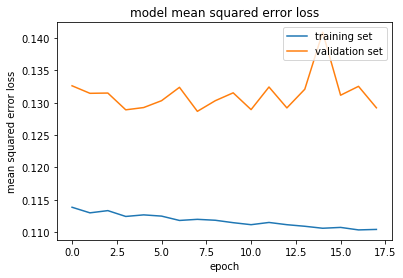

In [27]:
finetunemodel(X_train,y_train,lr=0.0001)

#### Saving a video of the autonomous agent

```
python drive.py model.h5 run2

python video.py run2
```

In [23]:
video_output = 'run2.mp4'

HTML("""
<video width="320" height="160" controls>
  <source src="{0}">
</video>
""".format(video_output))